[View in Colaboratory](https://colab.research.google.com/github/silentvoice/dl-with-keras/blob/master/image-generation-using-vae.ipynb)

# Image generation using variational autoencoders

In [0]:
# this resets the state of the machine (e.g. if you want to re-install from scratch  # this  
# or reset memory usage in this instance)
# wait a minute after running it and then reload the page
#!kill -9 -1

## Check Tensorflow Version

In [0]:
import tensorflow as tf

In [19]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [20]:
tf.__version__

'1.9.0'

## Imports

In [0]:
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [0]:
K.clear_session()

## Create an Encoder

In [0]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2 

In [0]:
input_img = keras.Input(shape=img_shape)

In [0]:
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

In [0]:
intermediate_encoder_shape = K.int_shape(x)

In [0]:
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

In [0]:
z_mean = layers.Dense(latent_dim)(x)
z_var = layers.Dense(latent_dim)(x)

In [0]:
def sampling(args):
  z_mean, z_var = args
  eps = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=1.)
  return z_mean + K.exp(z_var) * eps

z = layers.Lambda(sampling)([z_mean, z_var])

## Create a Decoder

In [0]:
decoder_input = layers.Input(K.int_shape(z)[1:])

In [0]:
x = layers.Dense(np.prod(intermediate_encoder_shape[1:]), activation='relu')(decoder_input)

In [0]:
x = layers.Reshape(intermediate_encoder_shape[1:])(x)

In [0]:
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)

In [0]:
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

In [0]:
decoder = Model(decoder_input, x)

In [0]:
z_decoded = decoder(z)

## Define Loss

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_var - K.square(z_mean) - K.exp(z_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x


y = CustomVariationalLayer()([input_img, z_decoded])

## Train the Model

In [0]:
vae = Model(input_img, y)

In [110]:
vae.compile(optimizer='rmsprop', loss=None)

In [111]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))


In [113]:
vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
48688/60000 [=======================>......] - ETA: 9s - loss: 0.2133

60000/60000 [==============================] - 53s 886us/step - loss: 0.2104 - val_loss: 0.1975
Epoch 2/10
31632/60000 [==============>...............] - ETA: 23s - loss: 0.1946

60000/60000 [==============================] - 52s 872us/step - loss: 0.1933 - val_loss: 0.1901
Epoch 3/10
24832/60000 [===========>..................] - ETA: 29s - loss: 0.1895

60000/60000 [==============================] - 52s 875us/step - loss: 0.1890 - val_loss: 0.1873
Epoch 4/10
22160/60000 [==========>...................] - ETA: 31s - loss: 0.1873

60000/60000 [==============================] - 52s 875us/step - loss: 0.1866 - val_loss: 0.1854
Epoch 5/10
21136/60000 [=========>....................] - ETA: 32s - loss: 0.1858

60000/60000 [==============================] - 52s 875us/step - loss: 0.1850 - val_loss: 0.1844
Epoch 6/10
20736/60000 [=========>....................] - ETA: 32s - loss: 0.1837

60000/60000 [==============================] - 52s 874us/step - loss: 0.1837 - val_loss: 0.1841
Epoch 7/10
20560/60000 [=========>....................] - ETA: 33s - loss: 0.1828

60000/60000 [==============================] - 52s 873us/step - loss: 0.1826 - val_loss: 0.1830
Epoch 8/10
20480/60000 [=========>....................] - ETA: 33s - loss: 0.1818

60000/60000 [==============================] - 52s 873us/step - loss: 0.1817 - val_loss: 0.1842
Epoch 9/10
20480/60000 [=========>....................] - ETA: 33s - loss: 0.1809

60000/60000 [==============================] - 52s 872us/step - loss: 0.1810 - val_loss: 0.1833
Epoch 10/10
20368/60000 [=========>....................] - ETA: 33s - loss: 0.1806

60000/60000 [==============================] - 52s 872us/step - loss: 0.1804 - val_loss: 0.1804


## Generate Images

In [0]:
n = 10  
digit_size = 28
img = np.zeros((digit_size * n, digit_size * n))

In [0]:
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

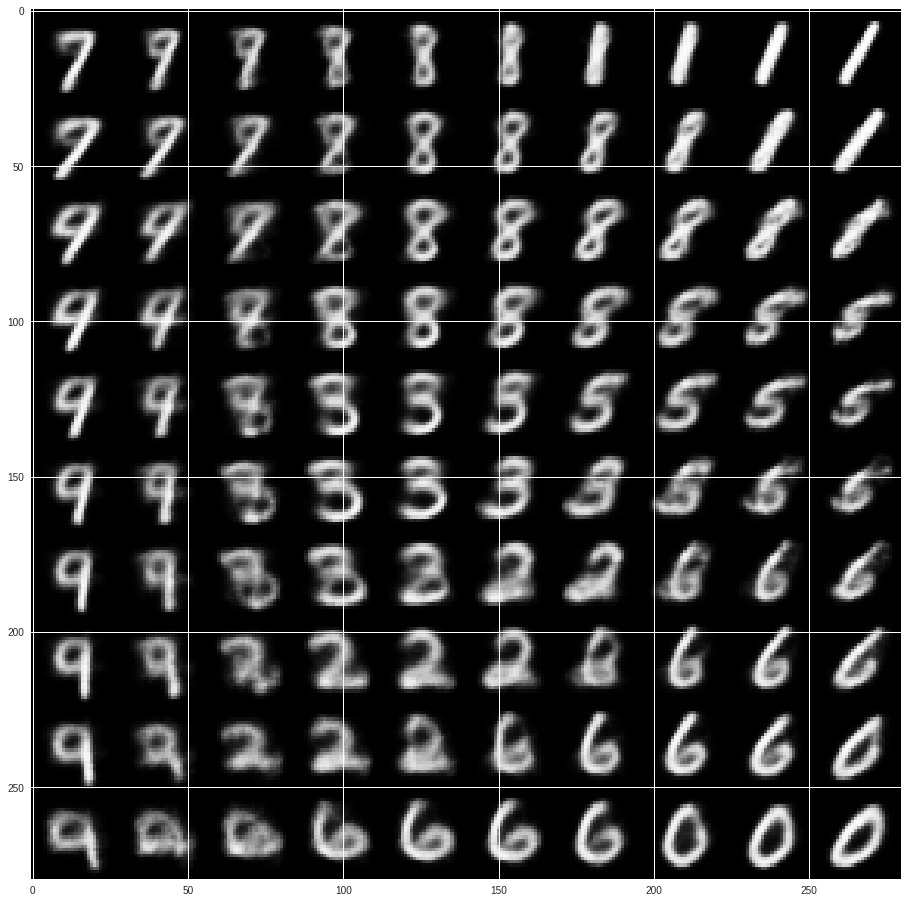

In [128]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        img[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(16, 16))
plt.imshow(img, cmap='Greys_r')